In [514]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize

import cv2
import math


def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x[::step_x]
    return x_positions, x_labels


In [515]:
path_out = 'mateusz\\'
files = glob.glob(path_out+"*")
files.sort()


In [516]:
dx= 5.106500953873407 
dt= 0.0016


data = []
first_filename = files[0]
for file in files[:6]:
   data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)


In [517]:
# This is an example transformation and should be converted to the proper algorithm
df -= df.mean()
df = np.abs(df)
low, high = np.percentile(df, [3, 99])
norm = Normalize(vmin=low, vmax=high, clip=True)

cols = df.columns
idx = df.index

# This function can show the plot with any array input
def show_figure(table, norm=norm):
    df = table
    if type(table) != pd.core.frame.DataFrame:
        df = pd.DataFrame(df, columns=cols, index=idx)

    fig = plt.figure(figsize=(12,16))
    ax = plt.axes()

    if norm is not None:
        im = ax.imshow(df,interpolation='none', aspect='auto', norm=norm)
    else:
        im = ax.imshow(df,interpolation='none', aspect='auto')
    
    plt.ylabel('time')
    plt.xlabel('space [m]')

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    plt.show()

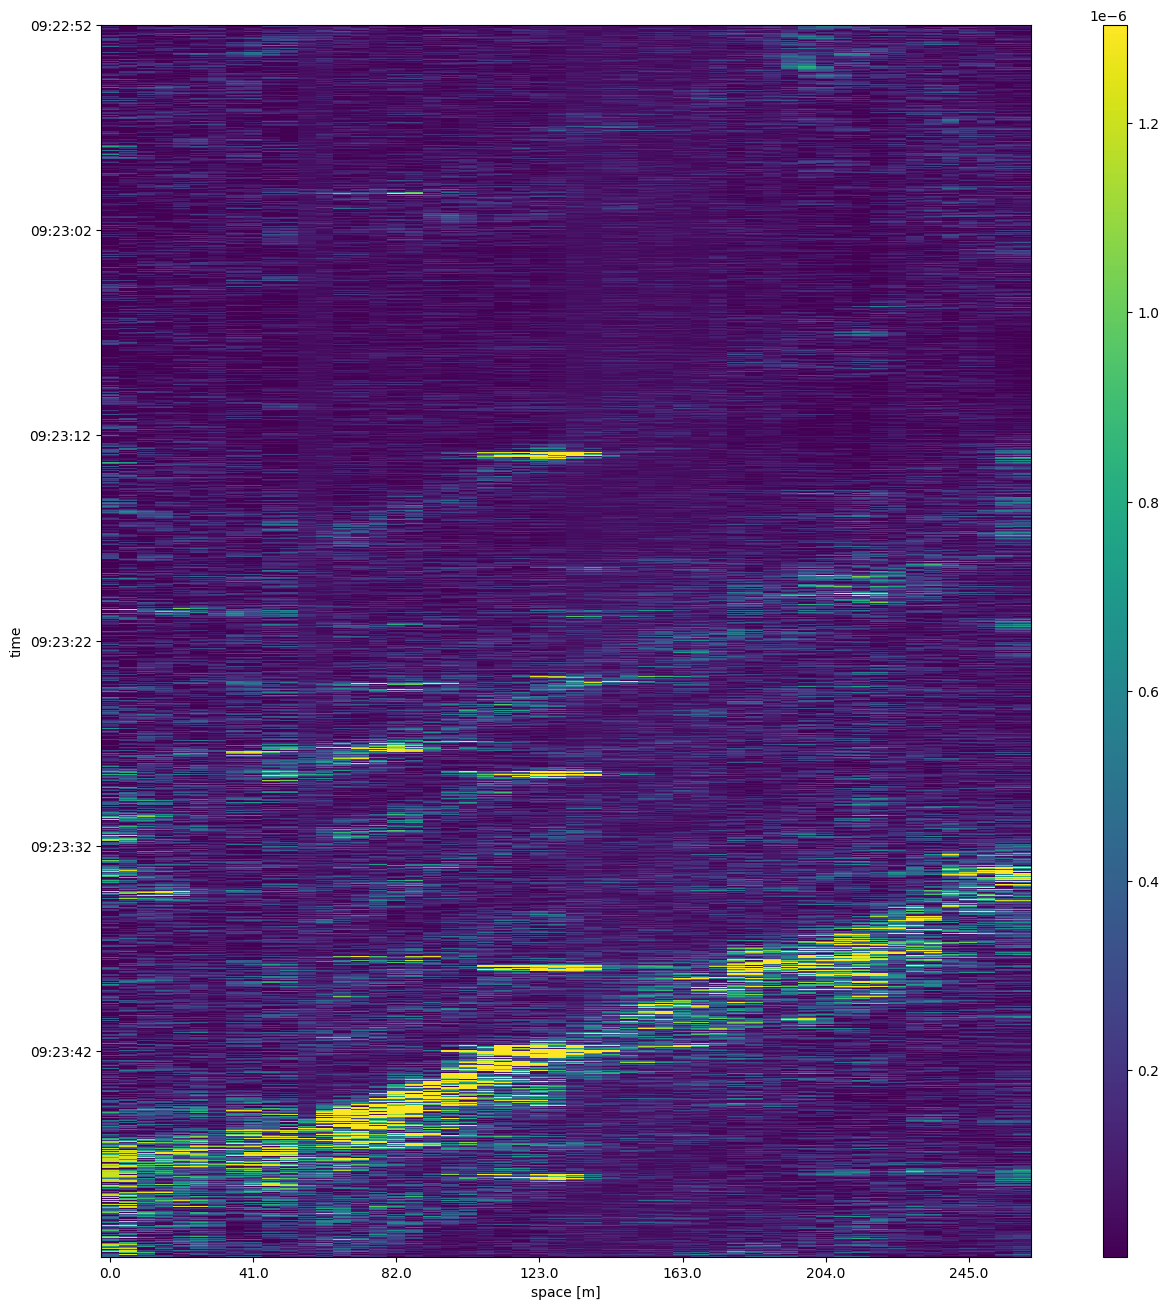

In [518]:
arr = np.array(df)

arr[arr > high] = high
arr[arr < low] = low

# arr[arr < np.mean(arr)] -= np.mean(arr[:3125,:])

arr_btrCol = np.copy(arr)
arr_btrCol = arr + np.median(arr) - np.median(arr, axis=0)

arr = arr_btrCol

show_figure(arr)

In [519]:
# def median_blur_rectangular(image, kernel_size):
#     """
#     Apply median blur with a rectangular kernel.
    
#     :param image: Input image (grayscale or color).
#     :param kernel_size: Tuple specifying the kernel size (height, width).
#     :return: Image after applying median blur.
#     """
#     k_height, k_width = kernel_size

#     # Pad the image to handle border pixels
#     pad_height = k_height // 2
#     pad_width = k_width // 2
#     padded_image = cv2.copyMakeBorder(image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_REFLECT)

#     # Create an empty output image
#     output = np.zeros_like(image)

#     # Sliding window over the image
#     for y in range(image.shape[0]):
#         for x in range(image.shape[1]):
#             # Extract the neighborhood (rectangular region)
#             region = padded_image[y:y + k_height, x:x + k_width]
            
#             # Compute the median and assign it to the central pixel
#             if len(image.shape) == 3:  # Color image
#                 for c in range(image.shape[2]):  # Process each channel
#                     output[y, x, c] = np.median(region[:, :, c])
#             else:  # Grayscale image
#                 output[y, x] = np.median(region)
    
#     return output

# kernel_size = (50, 5)
# blurred_image = median_blur_rectangular(arr, kernel_size)
# # show_figure(blurred_image)

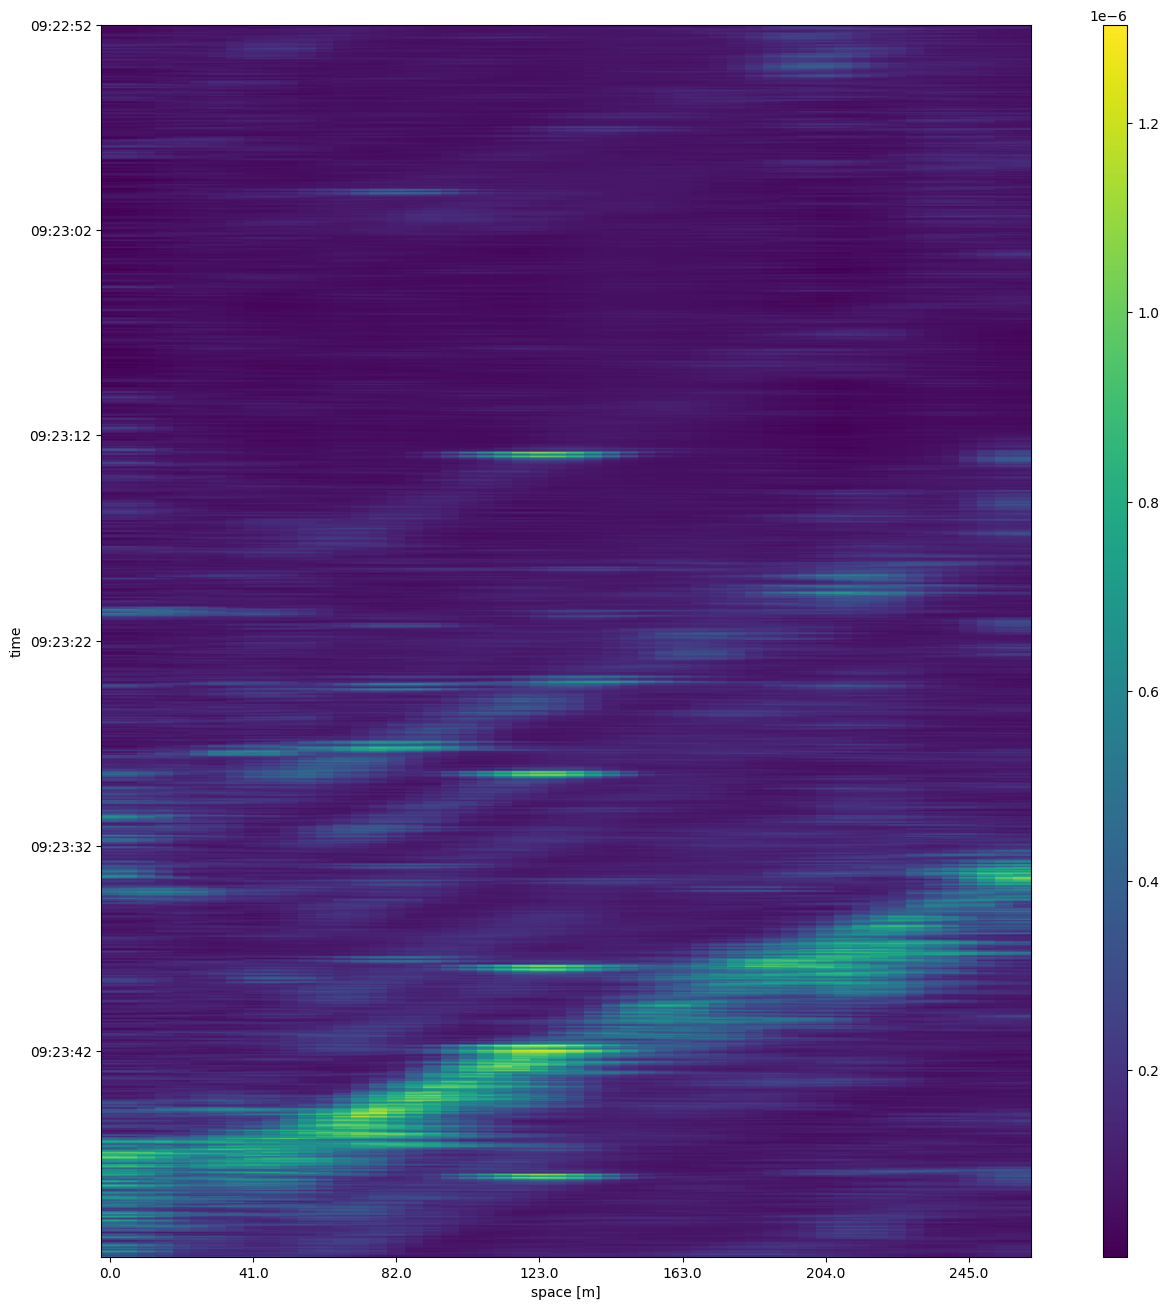

In [520]:
kernel_size = (51, 5)
kernel = np.ones((kernel_size[0],kernel_size[1])) / (kernel_size[0]*kernel_size[1])
arr_blurred = cv2.filter2D(arr, kernel=kernel, ddepth=-1)

show_figure(arr_blurred)

kernel_size = (11, 3)
kernel = np.ones((kernel_size[0],kernel_size[1])) / (kernel_size[0]*kernel_size[1])
arr_blurred2 = cv2.filter2D(arr_blurred, kernel=kernel, ddepth=-1)

# show_figure(arr_blurred2)

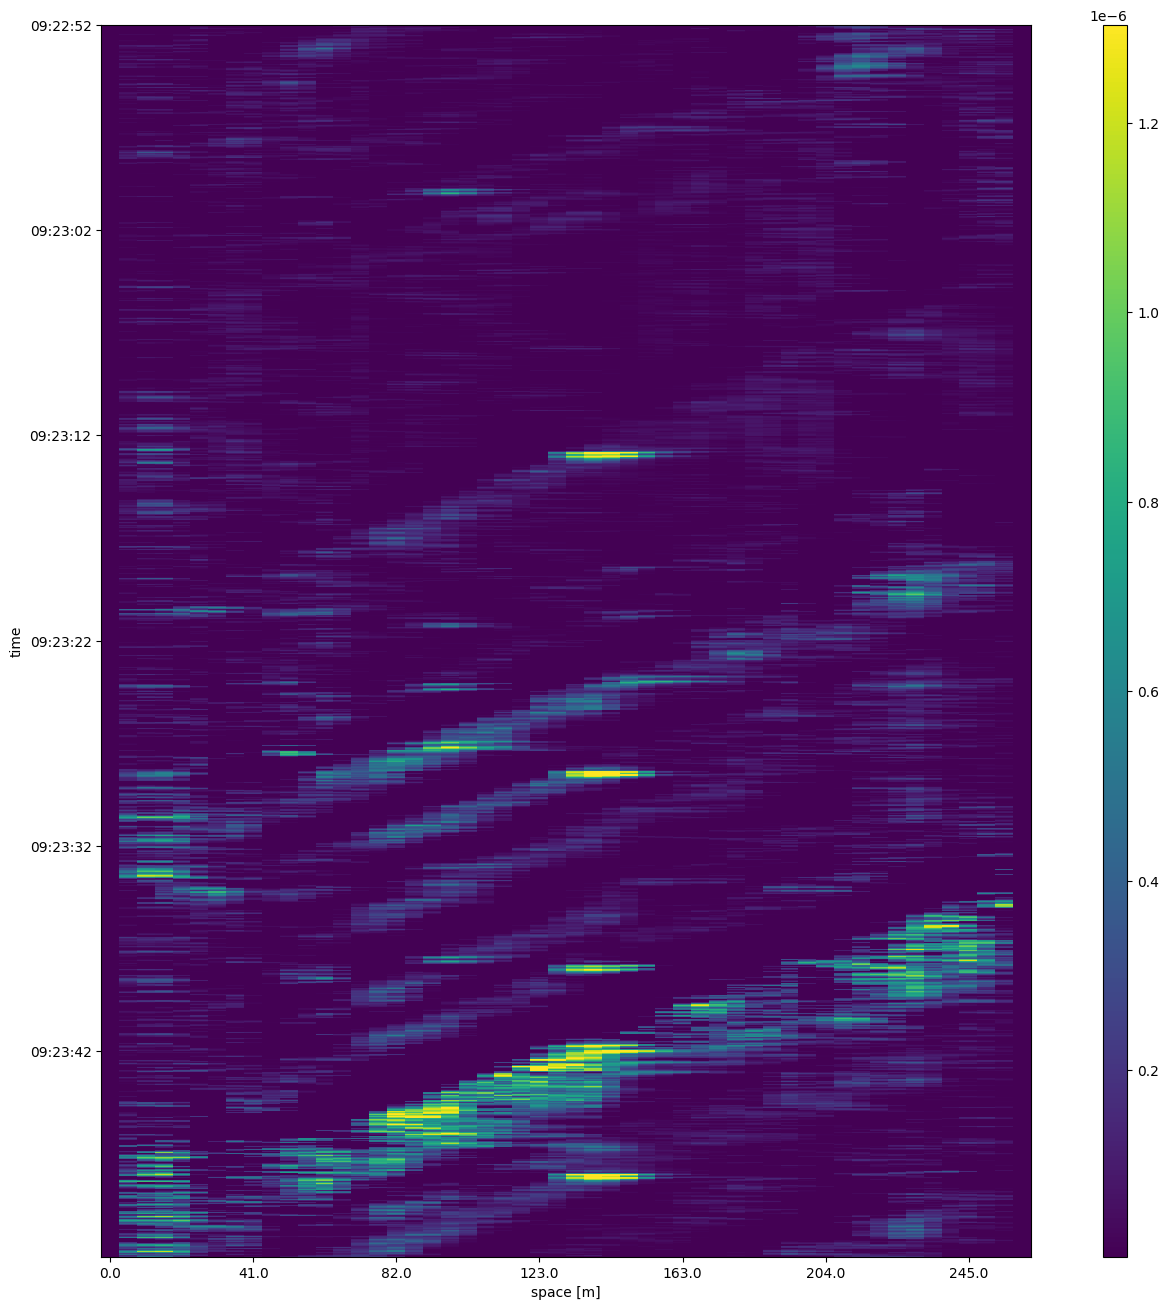

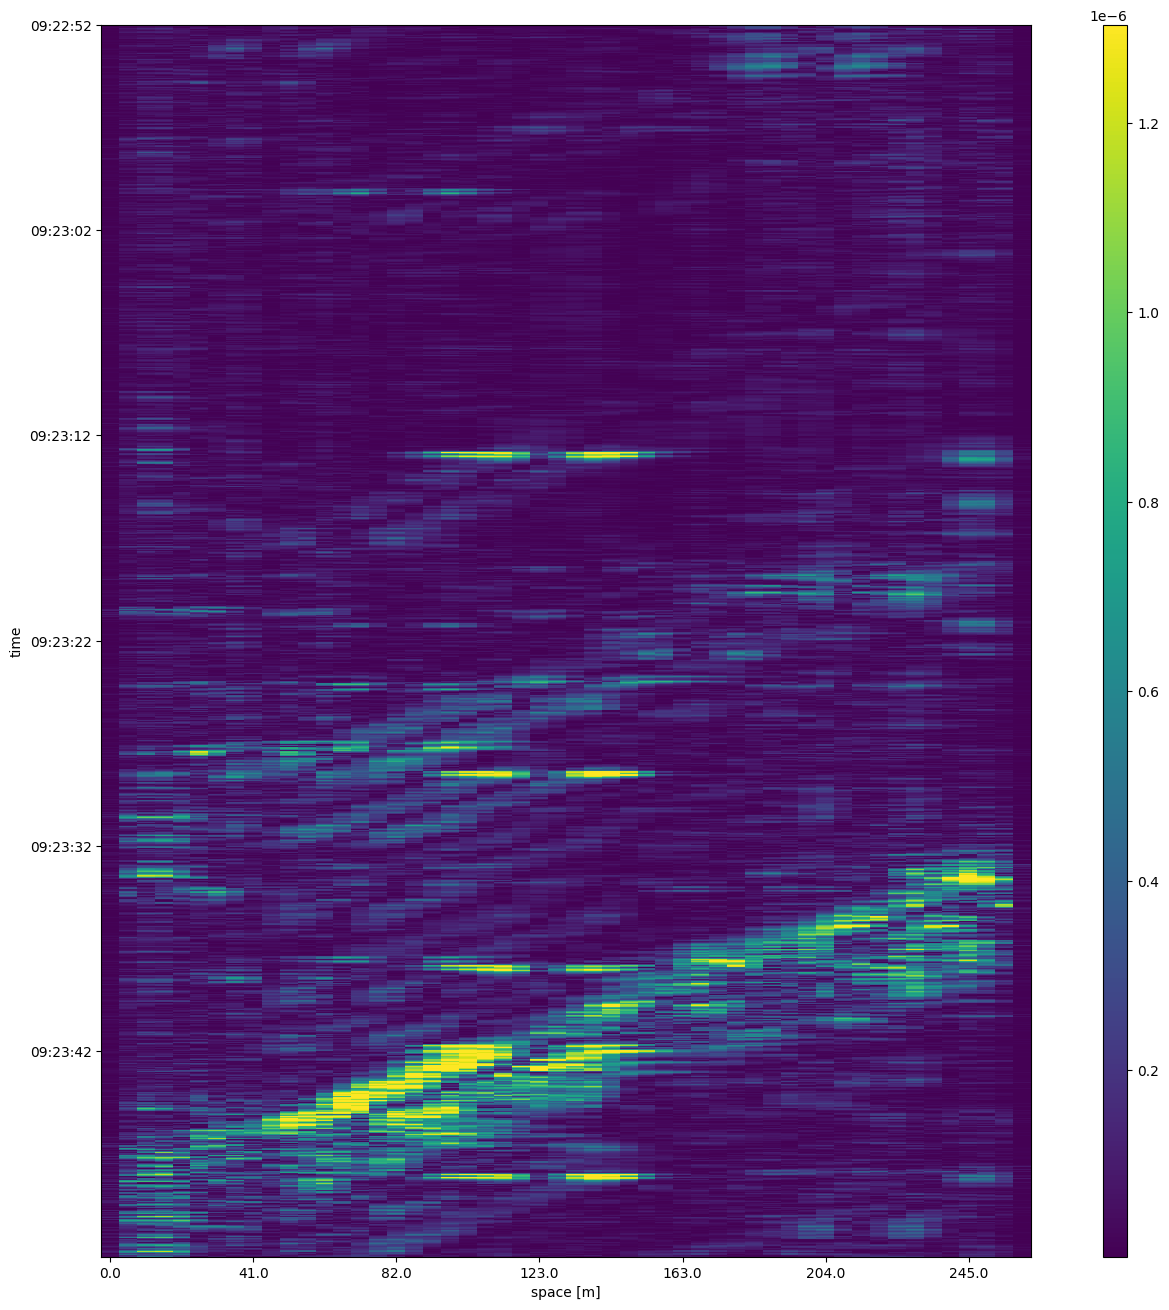

In [521]:
sobel_x = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
img_sobel_x = cv2.filter2D(arr_blurred, -1, sobel_x)
img_sobel_y = cv2.filter2D(arr_blurred, -1, sobel_y)
img_sobel = np.hypot(img_sobel_x, img_sobel_y)

show_figure(img_sobel_x)
# show_figure(img_sobel_y)
show_figure(img_sobel)

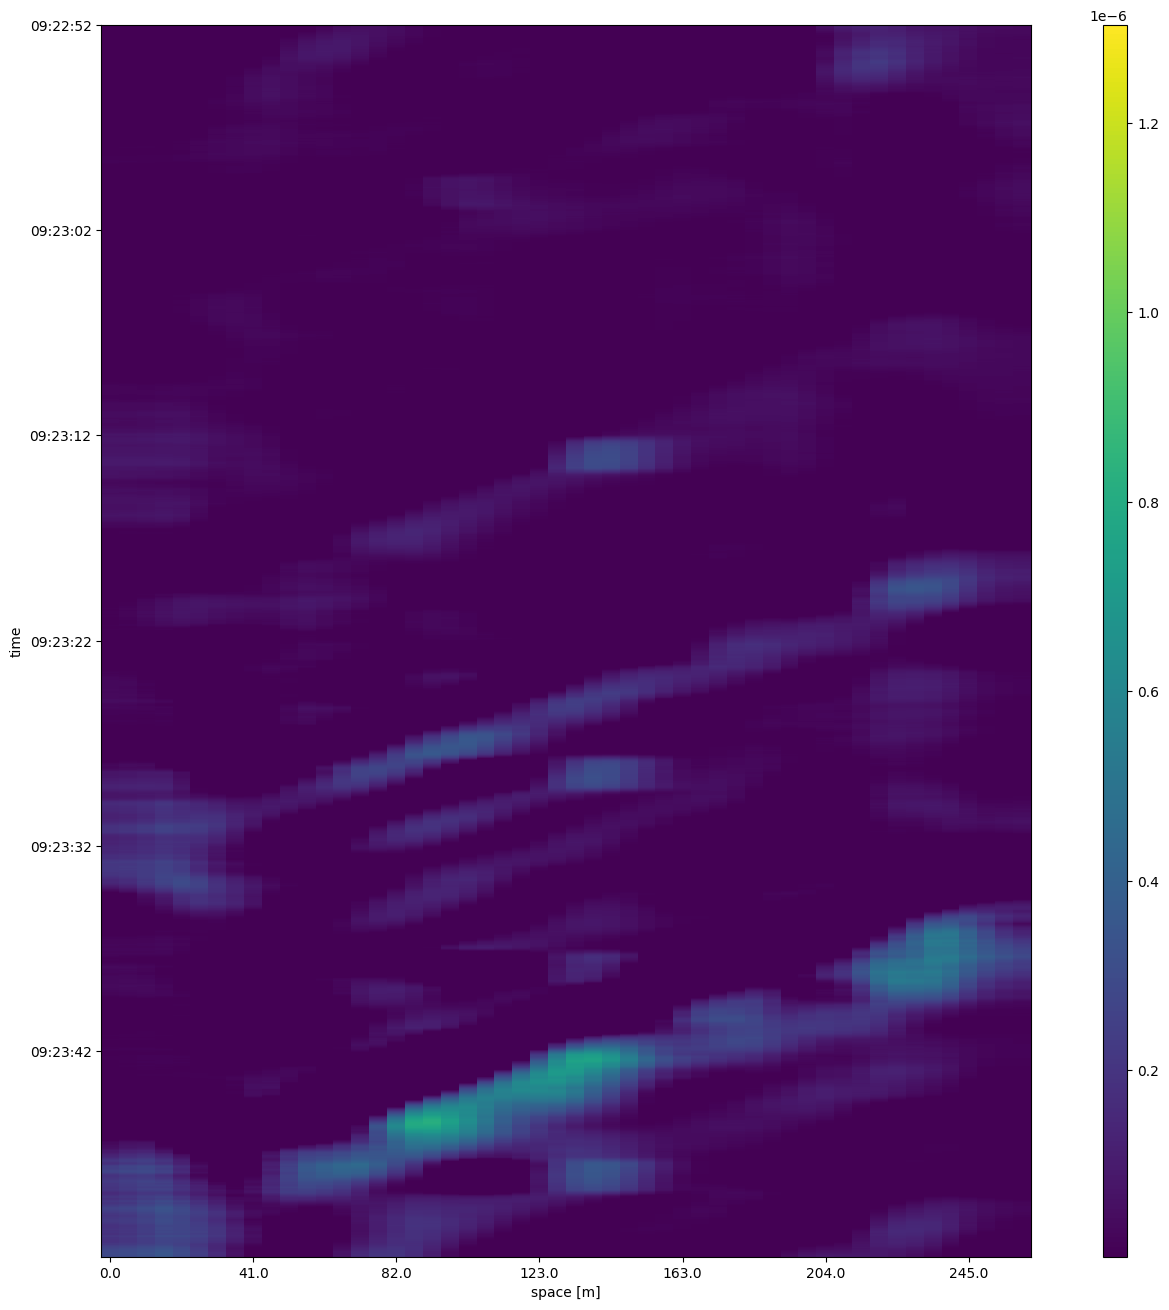

In [522]:
kernel_size = (1001, 5)
kernel = np.ones((kernel_size[0],kernel_size[1])) / (kernel_size[0]*kernel_size[1])
sobel_blurred = cv2.filter2D(img_sobel_x, kernel=kernel, ddepth=-1)

show_figure(sobel_blurred)

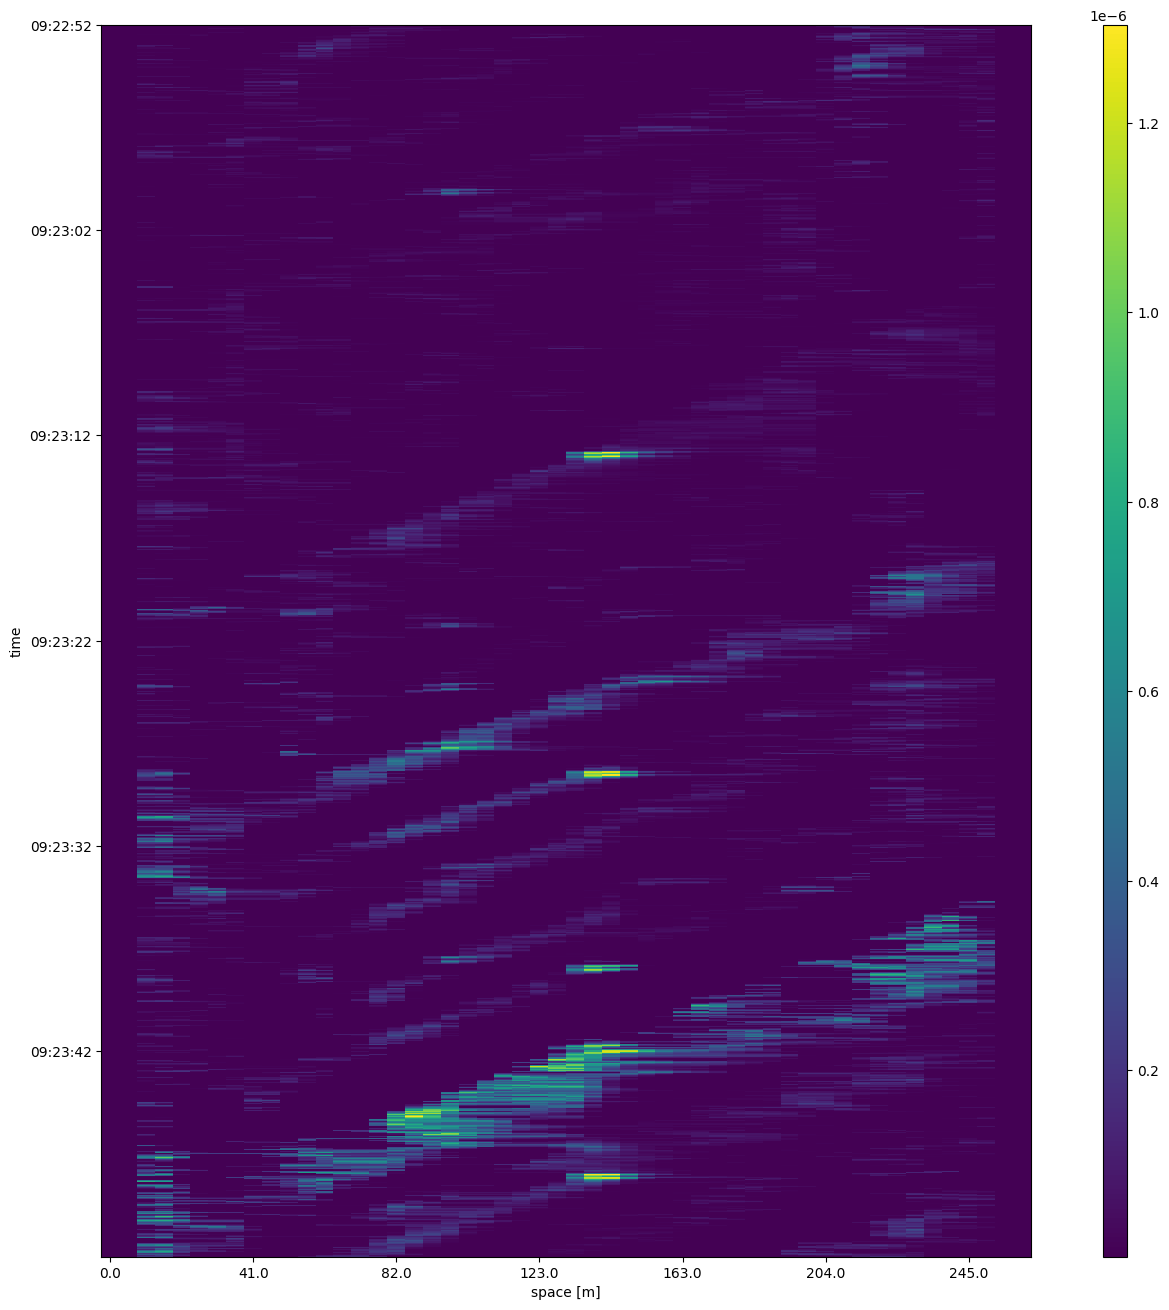

In [523]:
struct = np.ones((3, 3), np.uint8)
arr_erode = cv2.erode(img_sobel_x, struct, iterations=1)

show_figure(arr_erode)

erode_sobel_x = cv2.filter2D(sobel_blurred, -1, sobel_x)
# show_figure(-erode_sobel_x)

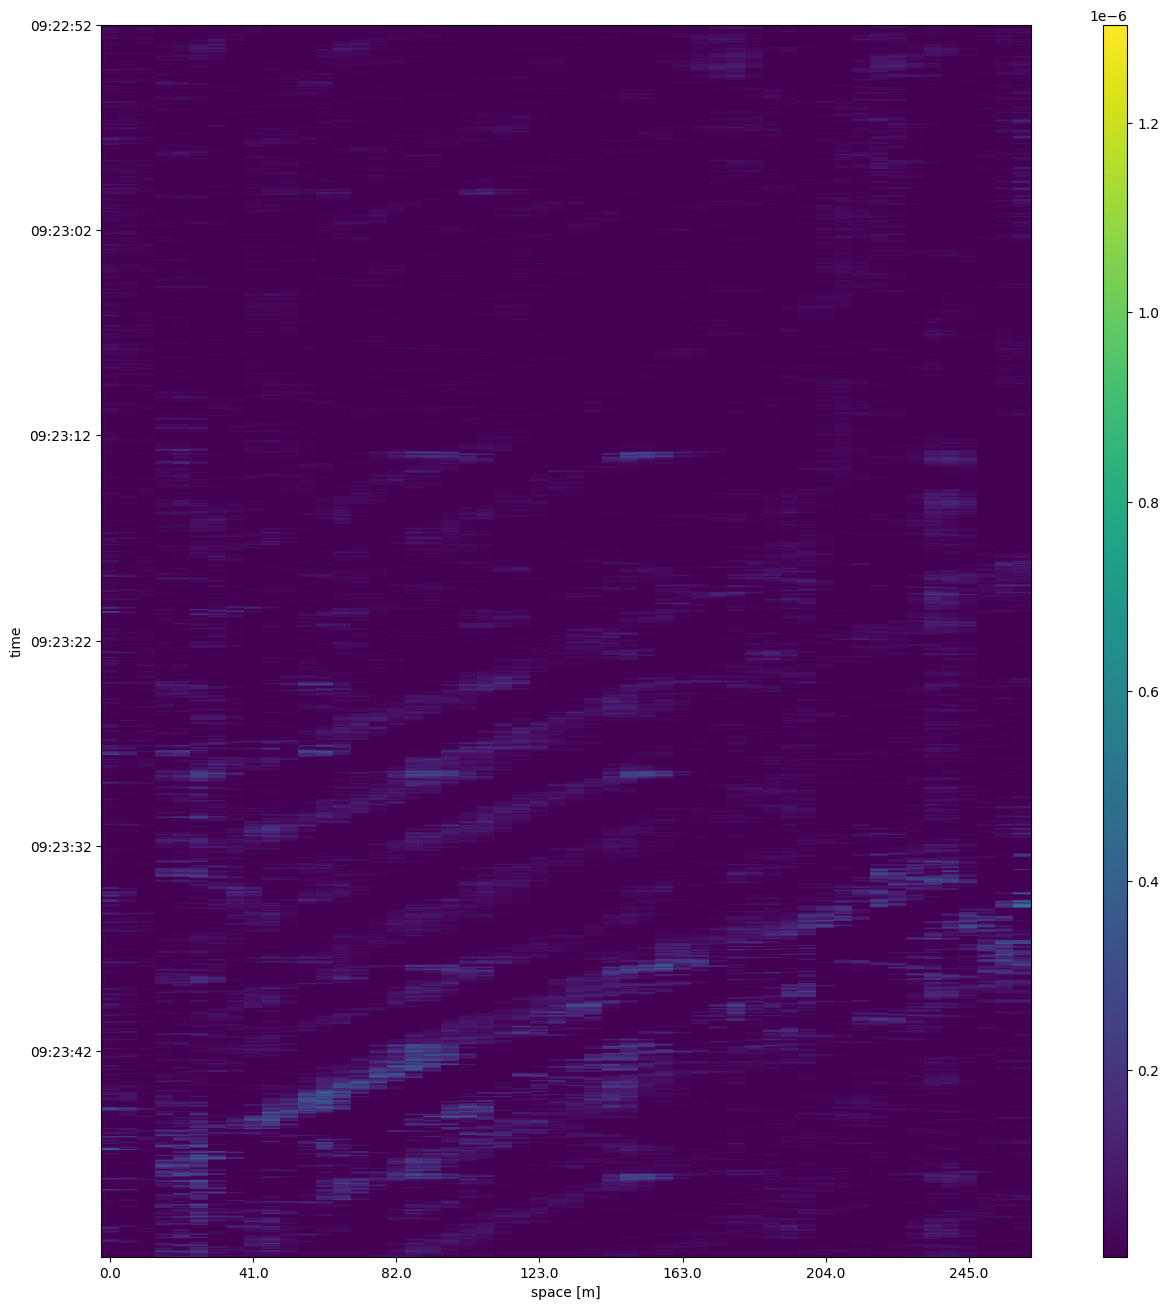

In [524]:
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
img_lapl = cv2.filter2D(arr_blurred2, -1, laplacian)

show_figure(img_lapl * 5)

In [525]:
def imshow(img, show=True, num_img=1, normalise=True):
    if normalise:
        img = np.float32(img)
        img = img - np.min(img)
        low, high = np.percentile(img, [3, 90])
        img *= 255 / high
    img[img > 255] = 255

    img = np.floor(img)
    img = np.uint8(img)
    img = cv2.resize(img, (256 * num_img, 512), interpolation=cv2.INTER_LINEAR)

    if show:
        cv2.imshow('ImageWindow', img)
        cv2.waitKey()
        cv2.destroyAllWindows()
    
    if not show:
        return img

In [526]:
imshow(np.concatenate([img_sobel_x, arr_erode], axis=1), True, 2)
# arr_erode looks better

In [527]:
def get_mask(s, div):
    mask = np.zeros(s, np.float32)
    return cv2.circle(mask, (s[0] // 2, s[1] // 2), s[0] // div, 1, -1)

def fft(img, size=None):
    f = np.fft.fft2(img, size)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift))
    return fshift, spectrum


def ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)

m = 1 - get_mask(arr_blurred.shape, 32) # This works quite ok
fshift, spectrum = fft(arr_blurred)
blurred_fourier = ifft(fshift * m)
imshow(blurred_fourier)

fshift, spectrum = fft(img_sobel_x)
img_back = ifft(fshift * m)
imshow(img_back)

fshift, spectrum = fft(sobel_blurred)
img_back = ifft(fshift * m)
imshow(img_back)

In [528]:
def imshow1(img, num=1):
    cv2.imshow('ImageWindow', cv2.resize(img, (256*num, 512), interpolation=cv2.INTER_LINEAR))
    cv2.waitKey()
    cv2.destroyAllWindows()

def hough(img, rho=10, threshold=50, mll=100, mlg=20):
    c_test_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    c_test_img_p = np.copy(c_test_img)

    # lines = cv2.HoughLines(img, 1, np.pi / 180, 75, None, 0, 0)
        
    # if lines is not None:
    #     for i in range(0, len(lines)):
    #         rho = lines[i][0][0]
    #         theta = lines[i][0][1]
    #         a = math.cos(theta)
    #         b = math.sin(theta)
    #         x0 = a * rho
    #         y0 = b * rho
    #         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    #         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    #         cv2.line(c_test_img, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

    linesP = cv2.HoughLinesP(img, rho, np.pi / 180, threshold, None, mll, mlg)

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(c_test_img_p, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

    # imshow(test_img)
    # imshow(c_test_img)
    imshow1(np.concatenate([cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), cv2.cvtColor(imshow(arr, show=False), cv2.COLOR_GRAY2BGR), c_test_img_p], axis=1), 3)

In [543]:
img = imshow(img_lapl, False)
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 2)
# imshow(img)

struct = np.ones((3, 3), np.uint8)
img = cv2.erode(img, struct, iterations=1)
# img = cv2.medianBlur(img, 3)

# hough(img, rho=1, threshold=15, mll=130, mlg=20)
# hough(img, rho=1, threshold=15, mll=80, mlg=10)
hough(img, rho=5, threshold=5, mll=80, mlg=10)